In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from spectral import SpectralNorm
import numpy as np

In [28]:
class SelfAttention(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.chanel_in = in_dim
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8 , kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8 , kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim , kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    
    def forward(self,x):
        """
        :param x: input feature maps(B X C X W X H)
        :returns out: self attention value + input feature 
        :returns attention: B X N X N (N is Width*Height)
        """
        B, C, W, H = x.size()
        N = W*H
        proj_query  = self.query_conv(x).view(B, -1, N).permute(0,2,1) # B X N X C we don't want to affect the Batch dimension
        proj_key =  self.key_conv(x).view(B, -1, N) # B X C x N
        energy =  torch.bmm(proj_query, proj_key) # transpose check
        attention = self.softmax(energy) # B X N X N
        proj_value = self.value_conv(x).view(B, -1, N) # B X C X N

        out = torch.bmm(proj_value, attention.permute(0,2,1))
        out = out.view(B, C, W, H)
        
        out = self.gamma*out + x
        return out, attention

In [33]:
t1 = torch.rand(32,64,60,60)
t2 = torch.rand(32,64,60,60)
sf = SelfAttention(64)

In [38]:
with torch.no_grad():
    x_out, x_attention = sf(t1)

In [41]:
x_out.size(), x_attention.size()

(torch.Size([32, 64, 60, 60]), torch.Size([32, 3600, 3600]))

In [42]:
import matplotlib.pyplot as plt

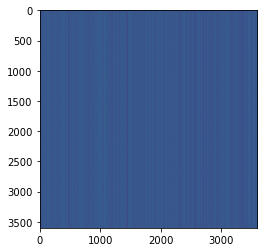

In [45]:
plt.imshow(x_attention[2])